## Exploring Cleaning and Wrangling Part 02
### this is starting from new data which includes games played info Sourced from SullyGnome.com


In [2]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [3]:
# imports
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install plotly

!{sys.executable} -m pip install collections
!{sys.executable} -m pip install xgboost

from collections import namedtuple
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [4]:
### This works but I should create a function that reads in the data.  

In [5]:
# twitch_df = pd.read_csv("twitch_clean_data_Kelly.csv", parse_dates=["Date"])
# twitch_df.head()

In [6]:
pd.set_option('display.max_columns', 130)
pd.set_option('display.max_rows', 130)

## Load Function

In [7]:
def load_twitch_data():
    cols = list(pd.read_csv("twitch_clean_data_Kelly02.csv", nrows=1))
    df = pd.read_csv("twitch_clean_data_Kelly02.csv", parse_dates=["Date"],
                    usecols = [i for i in cols if i !="Unnamed: 71"])
    return df

In [8]:
twitch_original_df = load_twitch_data()


In [9]:
twitch_df = twitch_original_df.copy()

### Ultimately I need to make a decision about how to split this data.

I think since her followers grow over time, I think the model should be given a random range of dates

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(twitch_df, minimal=True).to_notebook_iframe()

profile

## Create Wrangle Function- 
    Date as index 
    Create new streamDateId using David's toordinal
    replace_list = ["inf", "Unknown"]
    twitch_df.fillna(value= 0)
    Create Other Game feature
    Create Total_Earn_Category
    Change various types to floats

In [11]:
def wrangle_twitch_data02(df):
    # fill the Nans
    df = df.fillna(value= 0)
    
    # replace the unknown game values with 0
    replace_list = ["inf", "Unknown"]
    df= df.replace(to_replace=replace_list, value=0)    
    
    # as a consequence of having strings the columns where not floats.
    # correct that.
    df["user_chatting_percent"]= df["user_chatting_percent"].astype(str).astype(float)
    df["avg_message_per_viewer"]= df["avg_message_per_viewer"].astype(str).astype(float)
    
    ## Create new streamDateId using David's toordinal
    # this basically ordinally encodes the date
    df["stream_date_id"] = df["Date"].map(datetime.datetime.toordinal)
    
    # Set the date to index I think.. not sure if it's necessary...
    # df = df.set_index("Date")
    
    # Create an other_column for dimension reduction
    df["other_game"] = [0 for x in range(0, 1159)]

    # Fill in other_game column
    bottom_games_streamed=df.loc[:, "DST":"Stream_Racer"].sum().sort_values(ascending=False).tail(58).index
    bottom_games_streamed
    
    concerned_columns_df = df[bottom_games_streamed]
    other_sum = []
    for i in range(len(concerned_columns_df)):
        row = concerned_columns_df.iloc[i]
        other_sum.append(row.sum())
        
    df["other_game"] = other_sum

    # drop the bottom_games_streamed
    df = df.drop(bottom_games_streamed, axis=1)
    
    # rearrange column order
    cols = df.columns.tolist()

    cols = ['Date','stream_date_id', 'player_mode', 'DST','ONI','Chatting',
     'Stardew', 'DD','Drawful2', 'Cuphead','Terraria','Escapists2', 'Choice_Chamber',
     'Jackbox', 'Hollow_Knight','Subnautica','Use_Your_Words','Moonlighter','Graveyard_Keeper',
     'Marbles','7D2D','Dream_Daddy','ARK',"other_game",'Average Viewers','Chat Messages',
     'Chatters','Clip Views','Clips Created','Follows','Hosts and Raids Viewers (%)',
     'Live Views','Max Viewers','Minutes Watched','Minutes Streamed','Unique Viewers',
     'day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5',
    'day_of_week_6','day_of_week_7','streak','activity','avg_message_per_viewer',
     'user_chatting_percent','Sub Revenue','Prime Revenue','Gifted Subs Revenue',
     'Bits Revenue','Ad Revenue','Extensions Revenue','Bounties Revenue','donations',
     'Prime Subs','Total Paid Subs','Tier 1 subs','Tier 2 subs', 'Tier 3 subs',
     'Total Gifted Subs','Gifted Tier 1 subs','Gifted Tier 2 subs', 'Gifted Tier 3 subs',
     'Total_Sub_Revenue','Total_Earnings']
    
    df =df[cols]

    # create earning_cat_target
    df["total_earn_cat"] = pd.qcut(df["Total_Earnings"], 3, labels=["not worth", "kinda worth", "def worth!"])
    
    # change these columns from cat to numerical
    df["Extensions Revenue"]= df["Extensions Revenue"].astype(str).astype(float)  
    df["Bounties Revenue"]= df["Bounties Revenue"].astype(str).astype(float)
    df["Tier 2 subs"]= df["Tier 2 subs"].astype(str).astype(float)
    df["player_mode"]= df["player_mode"].astype(str).astype(float)

    return df
    
    

## Wrangle the Dataset!

In [12]:
twitch_df = wrangle_twitch_data02(twitch_df)
twitch_df.head()

Date  stream_date_id  player_mode  DST  ONI  Chatting  Stardew   DD  \
0 2017-06-13          736493          1.0  0.0  1.0       0.0      0.0  0.0   
1 2017-06-14          736494          1.0  0.0  1.0       0.0      0.0  0.0   
2 2017-06-15          736495          2.0  1.0  0.0       0.0      0.0  0.0   
3 2017-06-16          736496          2.0  1.0  0.0       0.0      0.0  0.0   
4 2017-06-17          736497          2.0  1.0  0.0       0.0      0.0  0.0   

   Drawful2  Cuphead  Terraria  Escapists2  Choice_Chamber  Jackbox  \
0       0.0      0.0       0.0         0.0             0.0      0.0   
1       0.0      0.0       0.0         0.0             0.0      0.0   
2       0.0      0.0       0.0         0.0             0.0      0.0   
3       0.0      0.0       0.0         0.0             0.0      0.0   
4       0.0      0.0       0.0         0.0             0.0      0.0   

   Hollow_Knight  Subnautica  Use_Your_Words  Moonlighter  Graveyard_Keeper  \
0            0.0         0.0             0.0          0.0               0.0   
1            0.0         0.0             0.0          0.0               0.0   
2            0.0         0.0             0.0          0.0               0.0   
3            0.0         0.0             0.0          0.0               0.0   
4            0.0         0.0             0.0          0.0               0.0   

   Marbles  7D2D  Dream_Daddy  ARK  other_game  Average Viewers  \
0      0.0   0.0          0.0  0.0         0.0             2.98   
1      0.0   0.0          0.0  0.0         0.0             3.47   
2      0.0   0.0          0.0  0.0         0.0             4.45   
3      0.0   0.0          0.0  0.0         0.0             3.73   
4      0.0   0.0          0.0  0.0         0.0             3.99   

   Chat Messages  Chatters  Clip Views  Clips Created  Follows  \
0            114         6           0              0        1   
1            260         9           0              0        2   
2             40         3           0              0        2   
3             38         5           0              0        2   
4            100         8           0              0        0   

   Hosts and Raids Viewers (%)  Live Views  Max Viewers  Minutes Watched  \
0                          0.0          11            5              480   
1                          0.0          35            8              653   
2                          0.0           1            8               89   
3                          0.0          17            6              421   
4                          0.0          16            7              591   

   Minutes Streamed  Unique Viewers  day_of_week_1  day_of_week_2  \
0               157               9              0              0   
1               192              26              0              0   
2                20               1              1              0   
3               115              13              0              1   
4               148              12              0              0   

   day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  day_of_week_7  \
0              0              0              0              1              0   
1              0              0              0              0              1   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              1              0              0              0              0   

   streak  activity  avg_message_per_viewer  user_chatting_percent  \
0       1  0.033333               12.666667              66.666667   
1       2  0.066667               10.000000              34.615385   
2       3  0.100000               40.000000             300.000000   
3       4  0.133333                2.923077              38.461538   
4       5  0.166667                8.333333              66.666667   

   Sub Revenue  Prime Revenue  Gifted Subs Revenue  Bits 

## Revenue per month on Main Channel

In [13]:
(twitch_df["Total_Earnings"].sum()/1159)*30

587.9244434857636

In [14]:
# Affiliate monthy wage according to CreatorHype.com
affiliate_monthly_df = pd.DataFrame({"Low End Affiliate Income": [12], "Median Affiliate Income": [319],
                                 "Stake Holder Income": [588], "High End Affiliate Income": [2701]})
affiliate_monthly_df

Low End Affiliate Income  Median Affiliate Income  Stake Holder Income  \
0                        12                      319                  588   

   High End Affiliate Income  
0                       2701

In [252]:

fig, ax = plt.subplots(figsize = (12,8))

# Set bg 

fig.set_facecolor("#F0F0F0")

# set graph background 

ax.set_facecolor("#F0F0F0")


# set label axis
plt.ylabel("$ per Month",fontsize=18, color= "#454545")


ax.set_xticklabels(labels=affiliate_monthly_df.columns, fontsize=14, color= "#454545")
ax.set_yticklabels(labels=[0,"$500", "$1000","$1500","$2000", "$2500", "$3000"], fontsize=17, color= "#454545")

# make graph 
plt.bar(x=affiliate_monthly_df.columns, height=affiliate_monthly_df.loc[0,:], width=.5,
        color= ["#0f4c5c","#0f4c5c", "#8C031C", "#0f4c5c",])



# set title
plt.title('Average Monthly Wage', fontweight="bold",
          fontsize=20, color= "#454545")

# Subtitle
subtitle_ = "Twitch Affiliate Streamers"
ax.text(s=subtitle_ ,fontsize=21, color= "#454545",
           x = .75, y= -450)

#remove spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('bar_chart_twitch_affiliate_average_monthly_wage_comparison.png', dpi=300, bbox_inches="tight")
plt.show()

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


In [16]:
plt.scatter(twitch_df["Total_Earnings"],
            twitch_df["Chatters"], alpha=.2)
plt.show()

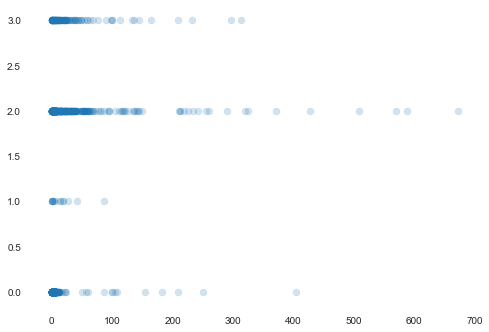

In [17]:
plt.scatter(twitch_df["Total_Earnings"],
            twitch_df["player_mode"], alpha=.2)
plt.show()

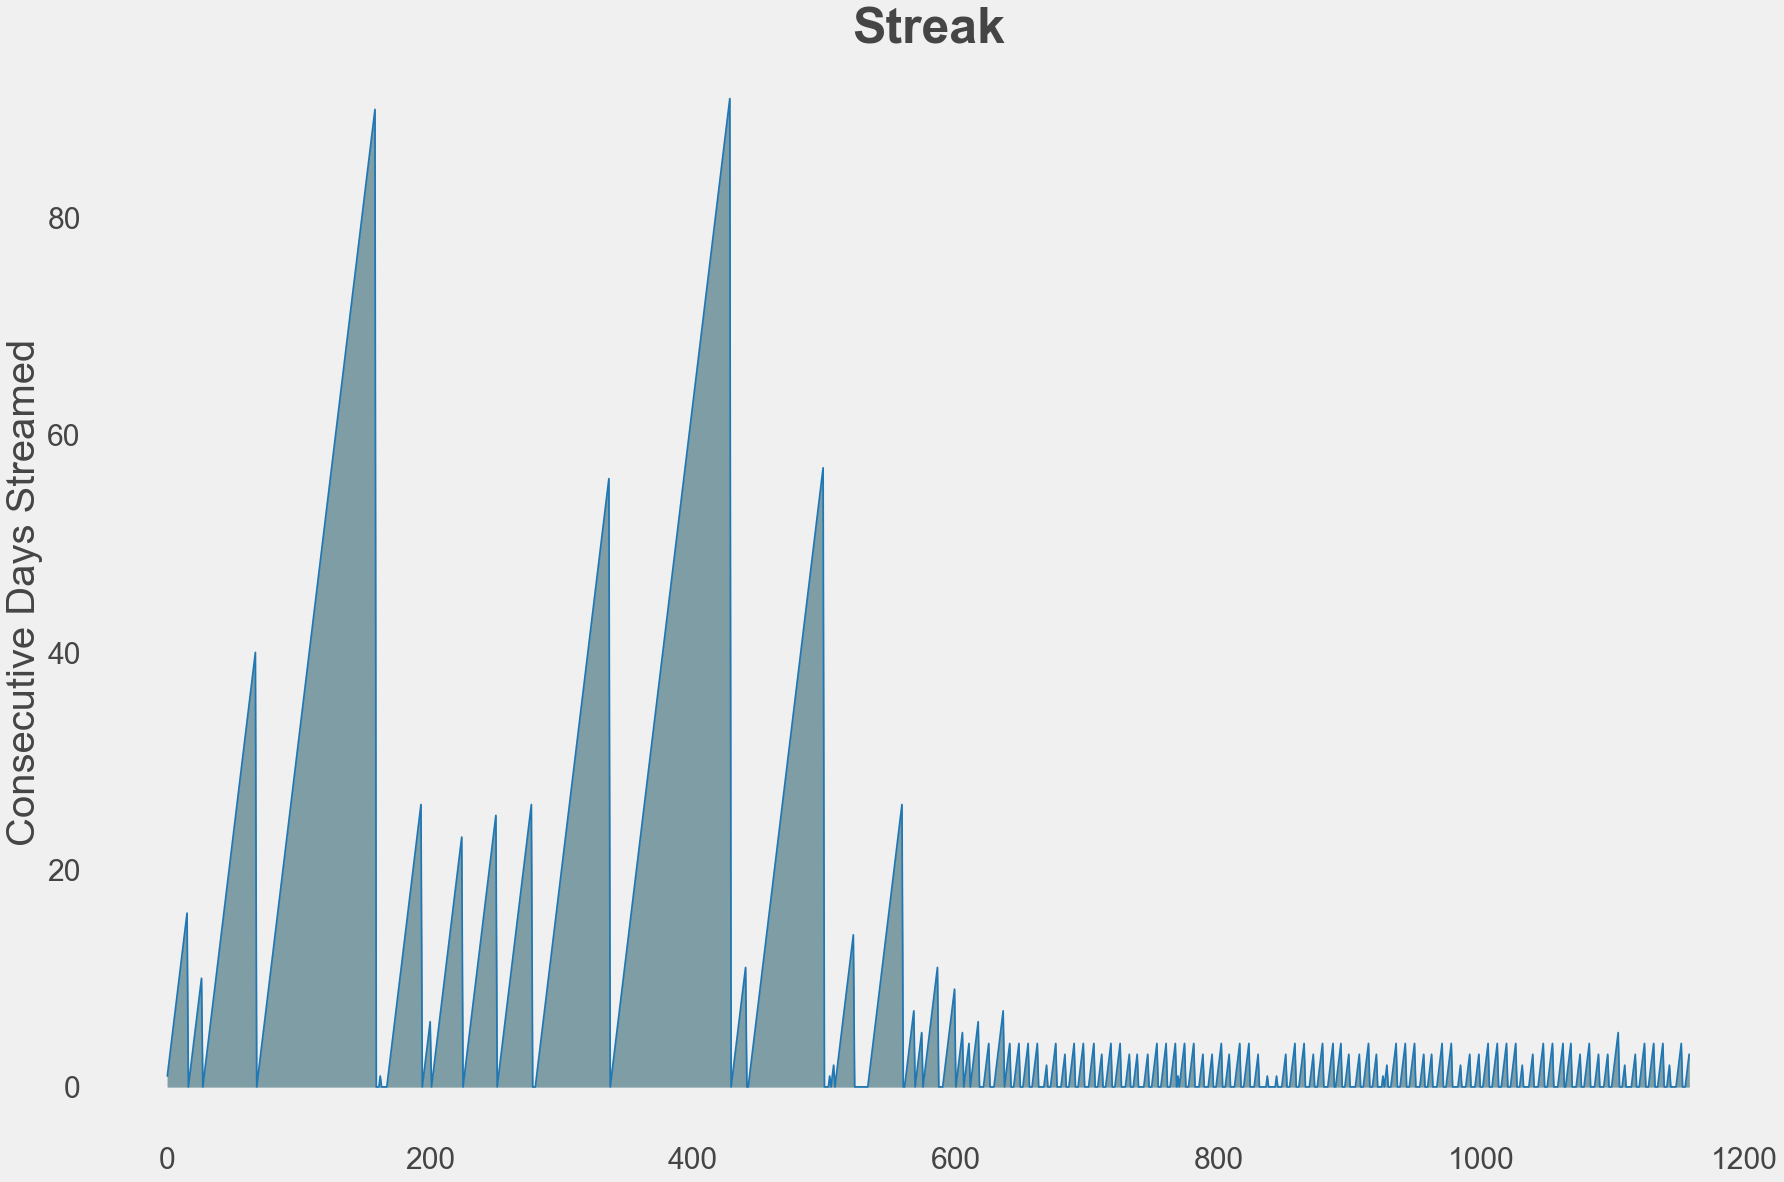

In [253]:
fig, ax = plt.subplots(figsize = (30,20))



# Set bg 

fig.set_facecolor("#F0F0F0")

# set graph background 

ax.set_facecolor("#F0F0F0")

#make graph


ax.plot(twitch_df["streak"])

# label axis
plt.ylabel("Consecutive Days Streamed", fontsize=40,
           x = -1000,color= "#454545")

plt.yticks(fontsize=30, color= "#454545")
plt.xticks(fontsize=30, color= "#454545")

# try to fill 
ax.fill_between(twitch_df["streak"].index, 0, twitch_df["streak"],
                color="#0f4c5c", alpha=0.50)

# rotate xticks

# set title
plt.title('Streak', fontsize=50, color= "#454545", fontweight = "bold")


#remove spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)



plt.savefig('streak_line_chart.png', dpi=300, bbox_inches="tight")

plt.show()

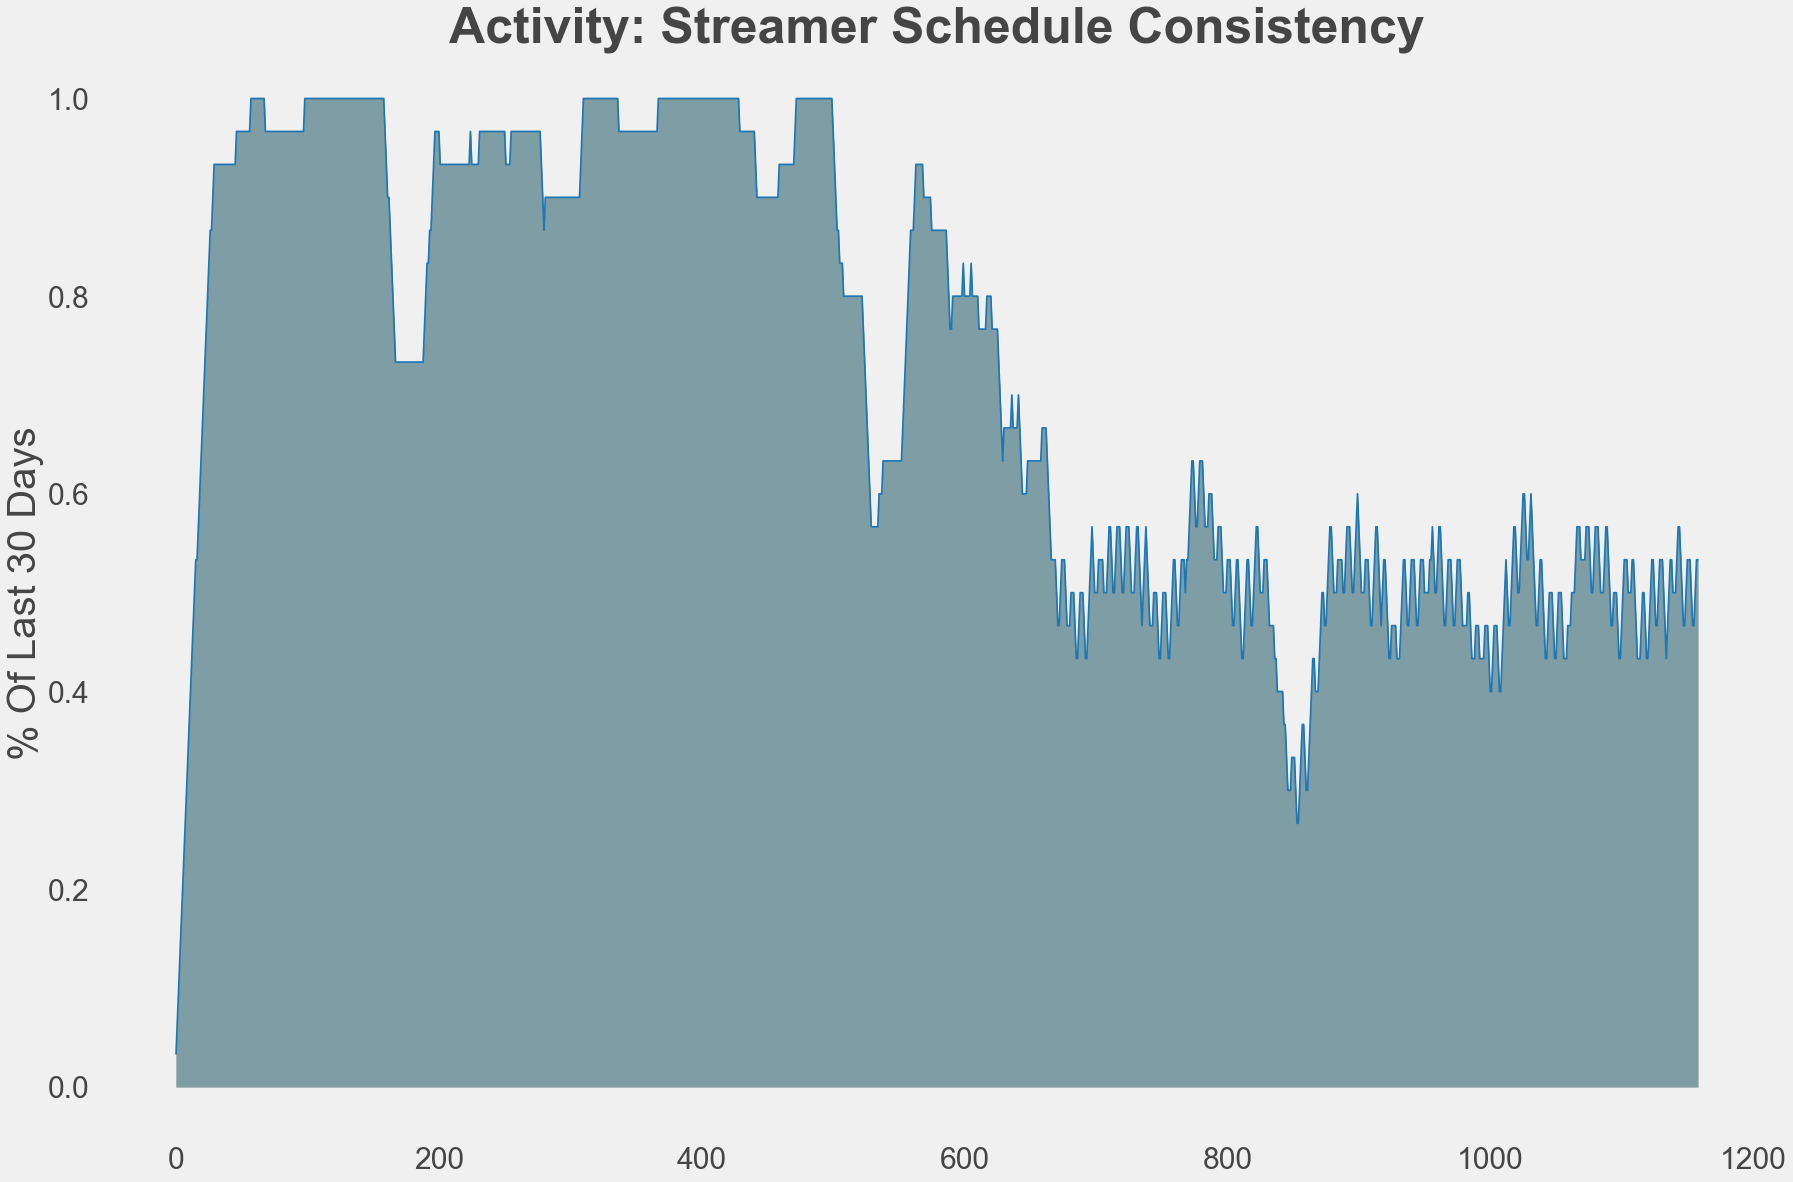

In [254]:
fig, ax = plt.subplots(figsize = (30,20))

# twitch_df.plot( y="activity", figsize =(30,18))

# Set bg 

fig.set_facecolor("#F0F0F0")

# set graph background 

ax.set_facecolor("#F0F0F0")

#make graph

ax.plot(twitch_df["activity"])

# try to fill 
ax.fill_between(twitch_df["activity"].index, 0, twitch_df["activity"],
                color="#0f4c5c", alpha=0.50)



# label axis
plt.ylabel("% Of Last 30 Days", fontsize=40,
           x = -1000,color= "#454545")

plt.yticks(fontsize=30, color= "#454545")
plt.xticks(fontsize=30, color= "#454545")


# set title
plt.title('Activity: Streamer Schedule Consistency', fontsize=50, color= "#454545", fontweight = "bold")

#remove spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('activity_line_chart.png', dpi=300, bbox_inches="tight")

plt.show()

In [20]:
corr_list = ['stream_date_id', 'player_mode', 'DST', 'ONI', 'Chatting',
       'Stardew', 'DD', 'Drawful2', 'Cuphead', 'Terraria', 'Escapists2',
       'Choice_Chamber', 'Jackbox', 'Hollow_Knight', 'Subnautica',
       'Use_Your_Words', 'Moonlighter', 'Graveyard_Keeper', 'Marbles', '7D2D',
       'Dream_Daddy', 'ARK', 'other_game', 'Average Viewers', 'Chat Messages',
       'Chatters', 'Clip Views', 'Clips Created', 'Follows',
       'Hosts and Raids Viewers (%)', 'Live Views', 'Max Viewers',
        'Minutes Streamed', 'Unique Viewers',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'streak', 'activity',
       'avg_message_per_viewer', 'user_chatting_percent', 'Total_Earnings',
       'total_earn_cat']

In [21]:
twitch_subset01_df = twitch_df[corr_list]
twitch_subset01_df.shape

(1159, 47)

In [22]:

# correlation matrix stuff - to see linear correlations
corr_matrix = twitch_subset01_df.corr()

In [23]:
corr_matrix["Total_Earnings"].sort_values(ascending=False)

Total_Earnings                 1.000000
Chatters                       0.333766
Chat Messages                  0.298061
Unique Viewers                 0.280546
Live Views                     0.278025
Clips Created                  0.261347
Hosts and Raids Viewers (%)    0.237196
Minutes Streamed               0.232080
Max Viewers                    0.215254
player_mode                    0.202948
Average Viewers                0.197042
Chatting                       0.193005
Marbles                        0.146199
avg_message_per_viewer         0.140919
other_game                     0.136930
DST                            0.129087
Jackbox                        0.112173
day_of_week_3                  0.107523
Escapists2                     0.105613
day_of_week_2                  0.090846
Stardew                        0.084417
Drawful2                       0.067253
7D2D                           0.058255
user_chatting_percent          0.056528
day_of_week_1                  0.055382


In [24]:
## NOTE: this is Absolute Value of correlation Matrix!!

In [117]:
middle_color = "#fb8b24"
worse_color= "#0f4c5c"
dnd_color ="#8C031C"

fig, ax = plt.subplots(figsize = (8,8))



# Set bg 

fig.set_facecolor("#F0F0F0")

# set graph background 

ax.set_facecolor("#F0F0F0")


# set label axis
plt.xlabel("(Absolute Value)",fontsize=15, color= "#454545")
plt.yticks(fontsize=15, color= "#454545")


# ax.set_xticklabels(labels=photog_hourly_df.columns, fontsize=13, color= "#454545")
# ax.set_yticklabels(labels=[0,10,20,30,40,50,60,70,80], fontsize=13, color= "#454545")

# make graph 
matr_colors = [worse_color, worse_color, worse_color, worse_color,
               worse_color,  dnd_color, worse_color,
               middle_color, worse_color,
                worse_color, worse_color,
               dnd_color, dnd_color, dnd_color, worse_color,]

corr_matrix["Total_Earnings"].abs().sort_values().tail(15).plot.barh(width=.7,
                                                                     color= matr_colors )

# corr_matrix["Total_Earnings"].abs().sort_values().tail(15).plot.barh()


# set title
plt.title('Linear Correlation to Earnings', fontsize=20,
          fontweight= "bold",
          color= "#454545")



#remove spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

plt.savefig('corr_Matrix_absolute_value_chart.png')

plt.show()

## Create the Feature Matrix from here


In [26]:
# make function that will do it for us
def get_naive_baseline(target_feature):
  guess = target_feature.mean()
  errors = guess - target_feature
  mean_absolute_error = errors.abs().mean()

  naive_baseline = namedtuple("baseline_info", ["guess", "errors", "MAE"])

  return naive_baseline(guess, errors, mean_absolute_error)

In [27]:
nbaseline = get_naive_baseline(twitch_df['Total_Earnings'])

In [28]:
print(f"If we estimated Total Earnings at ${nbaseline.guess},")
print(f"we would be off by ${nbaseline.MAE} on average.")

If we estimated Total Earnings at $19.597481449525453,
we would be off by $24.54002158371927 on average.


In [29]:
# print("Baseline MAE:\n", mean_absolute_error(df['price'], [df['price'].mean()]*400716))
# print("Baseline RMSE:\n", math.sqrt(mean_absolute_error(twitch_df['Total_Earnings']),
#                         twitch_df['Total_Earnings'].mean()]*len(twitch_df['Total_Earnings'].iloc[:,0])))
# print('\nTraining MAE:\n', mean_absolute_error(y_train, boost_model.predict(X_train)))

In [30]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
# print("Baseline MAE:\n", mean_absolute_error(df['price'], [df['price'].mean()]*len(df['price'])))
print("Baseline RMSE:\n", math.sqrt(mean_squared_error(twitch_df['Total_Earnings'],
                        [twitch_df['Total_Earnings'].mean()]*len(twitch_df['Total_Earnings']))))

Baseline RMSE:
 54.40829458760197


In [32]:
print(nbaseline.guess)
print(nbaseline.MAE)
print(nbaseline.errors.shape)

19.597481449525453
24.54002158371927
(1159,)


### y_pred = column of average predictions

In [33]:
y_pred = [twitch_df["Total_Earnings"].mean()] * len(twitch_df["Total_Earnings"])
# y_pred

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
y_target = twitch_df['Total_Earnings']

In [36]:
t_mse=mean_squared_error(y_target, y_pred)
t_rmse= mean_squared_error(y_target, y_pred, squared=False)

In [37]:
print(t_mse)
print(t_rmse)

2960.2625199312783
54.40829458760197


### R2 - ratio of difference of prediction and actual values

In [38]:
r2 = r2_score(y_target, y_pred)
print(r2)

0.0


In [39]:
# np.set_printoptions(threshold=sys.maxsize)
# twitch_df.columns

# list for Feature Matrix
long_list = [ 'player_mode', 'DST', 'ONI', 'Chatting',
       'Stardew', 'DD', 'Drawful2', 'Cuphead', 'Terraria', 'Escapists2',
       'Choice_Chamber', 'Jackbox', 'Hollow_Knight', 'Subnautica',
       'Use_Your_Words', 'Moonlighter', 'Graveyard_Keeper', 'Marbles', '7D2D',
       'Dream_Daddy', 'ARK', 'other_game', 'Average Viewers', 'Chat Messages',
       'Chatters', 'Clip Views', 'Clips Created', 'Follows',
       'Hosts and Raids Viewers (%)', 'Live Views', 'Max Viewers',
        'Minutes Streamed', 'Unique Viewers',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'streak', 'activity',
       'avg_message_per_viewer', 'user_chatting_percent', 'Total_Earnings',
       'total_earn_cat']

In [40]:
long_list = [ 'player_mode', 'DST', 'ONI', 'Chatting',
       'Stardew', 'DD', 'Drawful2', 'Cuphead', 'Terraria', 'Escapists2',
       'Choice_Chamber', 'Jackbox', 'Hollow_Knight', 'Subnautica',
       'Use_Your_Words', 'Moonlighter', 'Graveyard_Keeper', 'Marbles', '7D2D',
       'Dream_Daddy', 'ARK', 'other_game', 'Average Viewers', 'Chat Messages',
       'Chatters', 'Clip Views', 'Clips Created', 'Follows',
       'Hosts and Raids Viewers (%)', 'Live Views', 'Max Viewers',
        'Minutes Streamed', 'Unique Viewers',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'streak', 'activity',
       'avg_message_per_viewer', 'user_chatting_percent', 'Total_Earnings',
       'total_earn_cat']

# Fork the feature Matrix for future use


In [41]:
# feature_matrix_df = twitch_df[short_list]
# fork the feature Matrix for future use

feature_matrix_df = twitch_df[long_list]

In [42]:
# Make a function to create Matrix and Target pre validation split
def create_regression_Xmatrix_ytarget(training_df):
  y_target = training_df["Total_Earnings"]
  X_matrix = training_df.drop(["Total_Earnings"] , axis=1)
  return (X_matrix, y_target)

In [43]:
# Make a function to create Matrix and Target pre validation split
def create_classification_Xmatrix_ytarget(training_df):
  y_target = training_df['total_earn_cat']
  X_matrix = training_df.drop(["Total_Earnings",'total_earn_cat'] , axis=1)
  return (X_matrix, y_target)

In [44]:
X_matrix, y_target = create_regression_Xmatrix_ytarget(feature_matrix_df)
print(X_matrix.shape)
print(y_target.shape)

(1159, 45)
(1159,)


# Train Val Test split

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_matrix, y_target, train_size=0.80, test_size=0.20,
    stratify= X_matrix['total_earn_cat'], random_state=42)

In [47]:
print(X_train_temp.shape)
print(y_train_temp.shape)
print(X_test.shape)
print(y_test.shape)

(927, 45)
(927,)
(232, 45)
(232,)


In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, train_size=0.80, test_size=0.20,
    stratify= X_train_temp['total_earn_cat'],random_state=42)

In [49]:
X_train = X_train.drop('total_earn_cat', axis=1)
X_val = X_val.drop('total_earn_cat', axis=1)
X_test = X_test.drop('total_earn_cat', axis=1)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(741, 44)
(741,)
(186, 44)
(186,)
(232, 44)
(232,)


# Let's make a pipeline!  (finally...!)

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import RidgeCV

In [52]:
# lr_model = make_pipeline(
#     SelectKBest(),
#     LinearRegression(normalize=True)
# )

In [53]:
lr_model = make_pipeline(
    SelectKBest(),
    RidgeCV(scoring='neg_mean_absolute_error',
           cv=15)
)

### Short list transforms - SelectKBest, 

### Linear Model - Ridge Regression


In [54]:
lr_model.fit(X_train, y_train)

/Users/kellycho/.local/share/virtualenvs/StarKells_Twitch_data-N6g9n_I3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Pipeline(steps=[('selectkbest', SelectKBest()),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=15,
                         scoring='neg_mean_absolute_error'))])

## Grid Search here would be good.  

In [55]:
training_MAE = mean_absolute_error(y_train, lr_model.predict(X_train))
training_MSE=mean_squared_error(y_train, lr_model.predict(X_train))
training_RMSE=mean_squared_error(y_train, lr_model.predict(X_train), squared=False)

In [56]:
validation_MAE = mean_absolute_error(y_val, lr_model.predict(X_val))
validation_MSE = mean_squared_error(y_val, lr_model.predict(X_val))
validation_RMSE = mean_squared_error(y_val, lr_model.predict(X_val), squared=False)
validation_r2_01 =  r2_score(y_val, lr_model.predict(X_val))

In [57]:
print(f"If we estimated Total Earnings at ${nbaseline.guess},")
print(f"we would be off by ${nbaseline.MAE} on average.")
# print("Baseline RMSE:\n", math.sqrt(mean_absolute_error(twitch_df['Total_Earnings'],
#                         [twitch_df['Total_Earnings'].mean()]*len(twitch_df['Total_Earnings']))))
print(f"Training MAE: {training_MAE}")
print(f"Training MSE: {training_MSE}")
print(f"Training RMSE: {training_RMSE}")

print()
print(f"Validation MAE: {validation_MAE}")
print(f"Validation MSE: {validation_MSE}")
print(f"Validation RMSE: {validation_RMSE}")
print(f"Validation R^2: {validation_r2_01}")

If we estimated Total Earnings at $19.597481449525453,
we would be off by $24.54002158371927 on average.
Training MAE: 25.859525453313523
Training MSE: 3486.079006484946
Training RMSE: 59.04302673885331

Validation MAE: 20.39515182264181
Validation MSE: 1150.2311757896243
Validation RMSE: 33.91505824541105
Validation R^2: 0.1666753288216105


In [58]:
# response_var_column04 = xgb_model.predict(X_train)
# model_rsme02 = mean_squared_error(y_train, response_var_column04, squared=False)
# model_r2_02 = r2_score(y_train, response_var_column04)

### Automate it. 

In [59]:
from sklearn.inspection import permutation_importance

## Make some Classification Models
### Use Majority Classifier/Accuracy as metric


#### I actually have to fork my Feature Matrix.  

In [60]:
feature_matrix_df.head(2)

player_mode  DST  ONI  Chatting  Stardew   DD  Drawful2  Cuphead  Terraria  \
0          1.0  0.0  1.0       0.0      0.0  0.0       0.0      0.0       0.0   
1          1.0  0.0  1.0       0.0      0.0  0.0       0.0      0.0       0.0   

   Escapists2  Choice_Chamber  Jackbox  Hollow_Knight  Subnautica  \
0         0.0             0.0      0.0            0.0         0.0   
1         0.0             0.0      0.0            0.0         0.0   

   Use_Your_Words  Moonlighter  Graveyard_Keeper  Marbles  7D2D  Dream_Daddy  \
0             0.0          0.0               0.0      0.0   0.0          0.0   
1             0.0          0.0               0.0      0.0   0.0          0.0   

   ARK  other_game  Average Viewers  Chat Messages  Chatters  Clip Views  \
0  0.0         0.0             2.98            114         6           0   
1  0.0         0.0             3.47            260         9           0   

   Clips Created  Follows  Hosts and Raids Viewers (%)  Live Views  \
0              0        1                          0.0          11   
1              0        2                          0.0          35   

   Max Viewers  Minutes Streamed  Unique Viewers  day_of_week_1  \
0            5               157               9              0   
1            8               192              26              0   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
0              0              0              0              0              1   
1              0              0              0              0              0   

   day_of_week_7  streak  activity  avg_message_per_viewer  \
0              0       1  0.033333               12.666667   
1              1       2  0.066667               10.000000   

   user_chatting_percent  Total_Earnings total_earn_cat  
0              66.666667             0.0      not worth  
1              34.615385             0.0      not worth

In [61]:
# fork the feature Matrix for future use
X_matrix, y_target = create_classification_Xmatrix_ytarget(feature_matrix_df)
print(X_matrix.shape)
print(y_target.shape)

(1159, 44)
(1159,)


In [62]:
X_matrix.head(2)

player_mode  DST  ONI  Chatting  Stardew   DD  Drawful2  Cuphead  Terraria  \
0          1.0  0.0  1.0       0.0      0.0  0.0       0.0      0.0       0.0   
1          1.0  0.0  1.0       0.0      0.0  0.0       0.0      0.0       0.0   

   Escapists2  Choice_Chamber  Jackbox  Hollow_Knight  Subnautica  \
0         0.0             0.0      0.0            0.0         0.0   
1         0.0             0.0      0.0            0.0         0.0   

   Use_Your_Words  Moonlighter  Graveyard_Keeper  Marbles  7D2D  Dream_Daddy  \
0             0.0          0.0               0.0      0.0   0.0          0.0   
1             0.0          0.0               0.0      0.0   0.0          0.0   

   ARK  other_game  Average Viewers  Chat Messages  Chatters  Clip Views  \
0  0.0         0.0             2.98            114         6           0   
1  0.0         0.0             3.47            260         9           0   

   Clips Created  Follows  Hosts and Raids Viewers (%)  Live Views  \
0              0        1                          0.0          11   
1              0        2                          0.0          35   

   Max Viewers  Minutes Streamed  Unique Viewers  day_of_week_1  \
0            5               157               9              0   
1            8               192              26              0   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
0              0              0              0              0              1   
1              0              0              0              0              0   

   day_of_week_7  streak  activity  avg_message_per_viewer  \
0              0       1  0.033333               12.666667   
1              1       2  0.066667               10.000000   

   user_chatting_percent  
0              66.666667  
1              34.615385

In [63]:
y_target.head(2)

0    not worth
1    not worth
Name: total_earn_cat, dtype: category
Categories (3, object): ['not worth' < 'kinda worth' < 'def worth!']

## Baseline Accuracy


In [64]:
print('Baseline Accuracy:', y_target.value_counts(normalize=True).max())

Baseline Accuracy: 0.3364969801553063


In [65]:
y_target.head()

0    not worth
1    not worth
2    not worth
3    not worth
4    not worth
Name: total_earn_cat, dtype: category
Categories (3, object): ['not worth' < 'kinda worth' < 'def worth!']

## Baseline Metrics Table

In [66]:
# Baseline Metrics table

baseline_metrics_df = pd.DataFrame({"Machine Learning Task": ["Regression", "Classification"],
                                    "Mean Absolute Error(MAE)": [24.54, "-"],"Majority Classifier/Accuracy": ["-",0.336]})
baseline_metrics_df


Machine Learning Task Mean Absolute Error(MAE) Majority Classifier/Accuracy
0            Regression                    24.54                            -
1        Classification                        -                        0.336

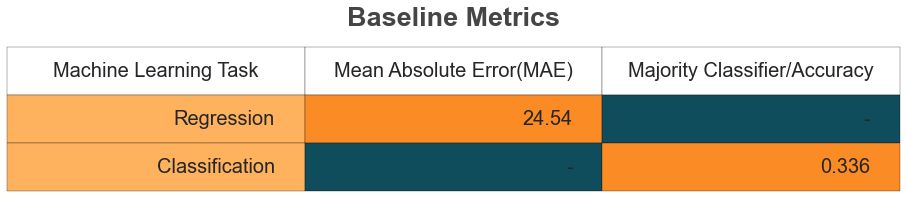

In [259]:
fig, axs = plt.subplots(figsize=(8,2))


lightbl_color = "#4780b3"
lighto_color = "#ffb25e"
middle_color = "#fb8b24"
worse_color= "#0f4c5c"
dnd_color ="#8C031C"


fig.patch.set_visible(False)

axs.axis("off")

colors = [[lighto_color,middle_color,worse_color],
          [lighto_color, worse_color, middle_color]]

table = axs.table(cellText=baseline_metrics_df.values,
          colLabels=baseline_metrics_df.columns,
          cellColours=colors,
                  loc = "center"
                  )
table.set_fontsize(25)
table.scale(2,4)



# set title
plt.title('Baseline Metrics', fontsize=27,
          fontweight= "bold",
          color= "#454545", y=1.3)



plt.savefig('baseline_metrics_table.png', dpi=300, bbox_inches="tight")


plt.show()

#### Train/Val/Test Split

In [174]:
from sklearn.model_selection import train_test_split

In [175]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_matrix, y_target, train_size=0.80, test_size=0.20,
    stratify=y_target, random_state=42)

In [176]:
print(X_train_temp.shape)
print(y_train_temp.shape)
print(X_test.shape)
print(y_test.shape)

(927, 44)
(927,)
(232, 44)
(232,)


In [177]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, train_size=0.80, test_size=0.20,
    stratify=y_train_temp,random_state=42)

In [178]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(741, 44)
(741,)
(186, 44)
(186,)
(232, 44)
(232,)


In [179]:
y_train.head()

130       not worth
224       not worth
258       not worth
1078      not worth
976     kinda worth
Name: total_earn_cat, dtype: category
Categories (3, object): ['not worth' < 'kinda worth' < 'def worth!']

In [180]:
from sklearn.tree import DecisionTreeClassifier # decision Tree for classification problems
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [181]:
class_tree_model_01 = make_pipeline(
    SelectKBest(),
    DecisionTreeClassifier(random_state=42)
)


In [182]:
param_grid = [
             { "selectkbest__k" : [5, 8, 10, 30],
              "decisiontreeclassifier__max_depth" : [8, 12, 15],
              "decisiontreeclassifier__min_samples_split" : [2, 4, 6, 10, 15]
             }
]

grid_search = GridSearchCV(class_tree_model_01, param_grid, cv = 10,
                           scoring="accuracy",
                           return_train_score=True,
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.3s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('selectkbest', SelectKBest()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'decisiontreeclassifier__max_depth': [8, 12, 15],
                          'decisiontreeclassifier__min_samples_split': [2, 4, 6,
                                                                        10,
                                                                        15],
                          'selectkbest__k': [5, 8, 10, 30]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [183]:
print('Best hyperparameters', grid_search.best_params_)

Best hyperparameters {'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__min_samples_split': 15, 'selectkbest__k': 30}


In [184]:
best_model_class_t_01 = grid_search.best_estimator_
best_model_class_t_01

Pipeline(steps=[('selectkbest', SelectKBest(k=30)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, min_samples_split=15,
                                        random_state=42))])

In [185]:
print(f"Training Accuracy: {best_model_class_t_01.score(X_train, y_train)}")
print(f"Validation Accuracy: {best_model_class_t_01.score(X_val, y_val)}")

Training Accuracy: 0.7260458839406208
Validation Accuracy: 0.543010752688172


In [186]:
print(f"Test Accuracy: {best_model_class_t_01.score(X_test, y_test)}")

Test Accuracy: 0.5043103448275862


### Confusion Matrix 


In [187]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [258]:



plot_confusion_matrix(best_model_class_t_01, X_val, y_val, 
                      values_format='.0f', 
                      display_labels=["Not Worth it", "Kinda Worth", "Definitely Worth"],
                      xticks_rotation=45,
                      cmap=plt.cm.Oranges);

# set title
plt.title('Decision Tree Confusion Matrix', fontsize=12,
          fontweight= "bold",
          color= "#454545",
          y=1.05)

plt.savefig('twitch_tree_classifier_confusion_matrix_chart.png', dpi=300, bbox_inches="tight")

plt.show()

## Try Permutation Importance for this model


In [189]:
from sklearn.inspection import permutation_importance

In [190]:
pi02 = permutation_importance(best_model_class_t_01, X_val, y_val)

In [191]:
pi02_df = pd.DataFrame({"importances_mean": np.round(pi02["importances_mean"], 4),
                     "importances_std": pi02["importances_std"]},
                    index=X_val.columns)

In [192]:
pi02_df.sort_values(by="importances_mean", ascending=False)

importances_mean  importances_std
Average Viewers                        0.0989         0.012540
player_mode                            0.0774         0.015433
Chatters                               0.0548         0.009250
avg_message_per_viewer                 0.0290         0.009972
Live Views                             0.0258         0.005268
day_of_week_7                          0.0172         0.006270
Chat Messages                          0.0129         0.014665
activity                               0.0108         0.011779
Clip Views                             0.0054         0.011779
Hosts and Raids Viewers (%)            0.0054         0.003400
other_game                             0.0043         0.005268
Max Viewers                            0.0032         0.005483
ARK                                    0.0000         0.000000
day_of_week_1                          0.0000         0.000000
day_of_week_5                          0.0000         0.000000
Follows                                0.0000         0.000000
day_of_week_6                          0.0000         0.000000
streak                                 0.0000         0.000000
Chatting                               0.0000         0.000000
DST                                    0.0000         0.000000
ONI                                    0.0000         0.000000
Dream_Daddy                            0.0000         0.000000
7D2D                                   0.0000         0.003400
Stardew                                0.0000         0.000000
DD                                     0.0000         0.000000
Drawful2                               0.0000         0.000000
Cuphead                                0.0000         0.000000
Terraria                               0.0000         0.000000
Escapists2                             0.0000         0.000000
Choice_Chamber                         0.0000         0.000000
user_chatting_percent                  0.0000         0.000000
Jackbox                                0.0000         0.000000
Hollow_Knight                          0.0000         0.000000
Subnautica                             0.0000         0.000000
Use_Your_Words                         0.0000         0.000000
Moonlighter                            0.0000         0.000000
Graveyard_Keeper                       0.0000         0.000000
Marbles                                0.0000         0.000000
day_of_week_2                         -0.0011         0.002151
Minutes Streamed                      -0.0043         0.033901
day_of_week_4                         -0.0043         0.002151
day_of_week_3                         -0.0065         0.004023
Unique Viewers                        -0.0075         0.009374
Clips Created                         -0.0204         0.004023

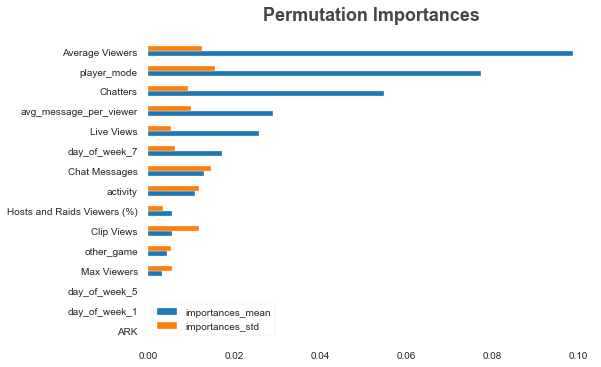

In [262]:
# pi02_df.sort_values(by="importances_mean", ascending=False).head(15).sort_values(by="importances_mean").plot(kind="barh")


# make graph 
matr_colors = [worse_color, worse_color, worse_color, worse_color,
               worse_color,  dnd_color, worse_color,
               middle_color, worse_color,
                worse_color, worse_color,
               dnd_color, dnd_color, dnd_color, worse_color,]



pi02_df.sort_values(by="importances_mean", ascending=False).head(15).\
  sort_values(by="importances_mean").\
  plot.barh(width=.5)



                                                        
# corr_matrix["Total_Earnings"].abs().sort_values().tail(15).plot.barh(width=.7,
#                                                                      color= matr_colors )


#remove spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Permutation Importances', fontsize=18,
          fontweight= "bold",
          color= "#454545",
          y=1.05)

plt.savefig('twitch_tree_classifier_permutation_importance_top15_bar_chart.png',  dpi=300, bbox_inches="tight")

plt.show()

## Decision Tree Classifier Shap stuff


In [88]:
X_matrix, y_target = create_classification_Xmatrix_ytarget(feature_matrix_df)
print(X_matrix.shape)
print(y_target.shape)

(1159, 44)
(1159,)


In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_matrix, y_target, train_size=0.80, test_size=0.20,
    stratify=y_target, random_state=42)

In [91]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, train_size=0.80, test_size=0.20,
    stratify=y_train_temp,random_state=42)

In [92]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(741, 44)
(741,)
(186, 44)
(186,)
(232, 44)
(232,)


In [93]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_matrix, y_target, train_size=0.80, test_size=0.20,
    stratify=y_target, random_state=42)

In [94]:
print(X_train_temp.shape)
print(y_train_temp.shape)
print(X_test.shape)
print(y_test.shape)

(927, 44)
(927,)
(232, 44)
(232,)


In [95]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, train_size=0.80, test_size=0.20,
    stratify=y_train_temp,random_state=42)

In [96]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(741, 44)
(741,)
(186, 44)
(186,)
(232, 44)
(232,)


In [97]:
pi02_df.sort_values(by="importances_mean", ascending=False).head(15).index

Index(['Average Viewers', 'player_mode', 'Chatters', 'Live Views',
       'day_of_week_7', 'avg_message_per_viewer', 'activity', 'Clip Views',
       'other_game', 'Hosts and Raids Viewers (%)', '7D2D', 'Unique Viewers',
       'day_of_week_2', 'DST', 'Max Viewers'],
      dtype='object')

In [98]:
dtc_feat = ['Chatters', 'activity', 'Clips Created', 'Chat Messages', 'Live Views',
       'Average Viewers', 'Unique Viewers', 'streak', 'Max Viewers',
       'user_chatting_percent', 'Stardew', 'avg_message_per_viewer',
       'Minutes Streamed', '7D2D', 'Follows']

# dtc_target = ["total_earn_cat"]

In [99]:
X_train = X_train[dtc_feat]
# y_train = y_train[dtc_target]

X_val = X_val[dtc_feat]
# y_val = y_val[dtc_target]

In [100]:
class_tree_model_01 =  DecisionTreeClassifier(max_depth=8, min_samples_split=15,
                                        random_state=42)
class_tree_model_01.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_split=15, random_state=42)

In [101]:
class_tree_model_01.predict(X_val)[178]

'def worth!'

In [102]:
row = X_val.iloc[[178]]
row

Chatters  activity  Clips Created  Chat Messages  Live Views  \
682        92       0.5              2           2790         450   

     Average Viewers  Unique Viewers  streak  Max Viewers  \
682             36.7             333       2           90   

     user_chatting_percent  Stardew  avg_message_per_viewer  Minutes Streamed  \
682              27.627628      0.0                8.378378               343   

     7D2D  Follows  
682   0.0       13

In [103]:
y_val.iloc[[178]]

682    def worth!
Name: total_earn_cat, dtype: category
Categories (3, object): ['not worth' < 'kinda worth' < 'def worth!']

In [104]:
y_val.tail(20)

153      def worth!
155      def worth!
1108      not worth
352       not worth
670     kinda worth
390       not worth
934      def worth!
253       not worth
534       not worth
834       not worth
920      def worth!
168       not worth
682      def worth!
481     kinda worth
494      def worth!
476      def worth!
663     kinda worth
888       not worth
428       not worth
879      def worth!
Name: total_earn_cat, dtype: category
Categories (3, object): ['not worth' < 'kinda worth' < 'def worth!']

In [105]:
y_val.shape

(186,)

## Actual force plot!

In [106]:
!pip install shap

In [107]:
import shap 

In [108]:
explainer = shap.TreeExplainer(class_tree_model_01)
shap_values = explainer.shap_values(row) # must be 2D array 


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


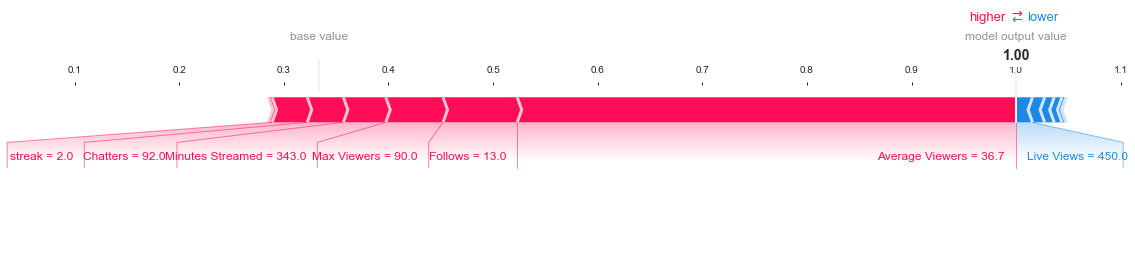

In [256]:
shap.initjs()
shap.force_plot(
    base_value= explainer.expected_value[0], # the index is for which classification value is being explained
    shap_values=shap_values[0],
    features=row,
    show=False,
    matplotlib=True)


plt.savefig('twitch_tree_classifier_shapley_top15_chart.png', dpi=300, bbox_inches="tight")

plt.show()


In [110]:
shap_values02 = explainer.shap_values(X_val)

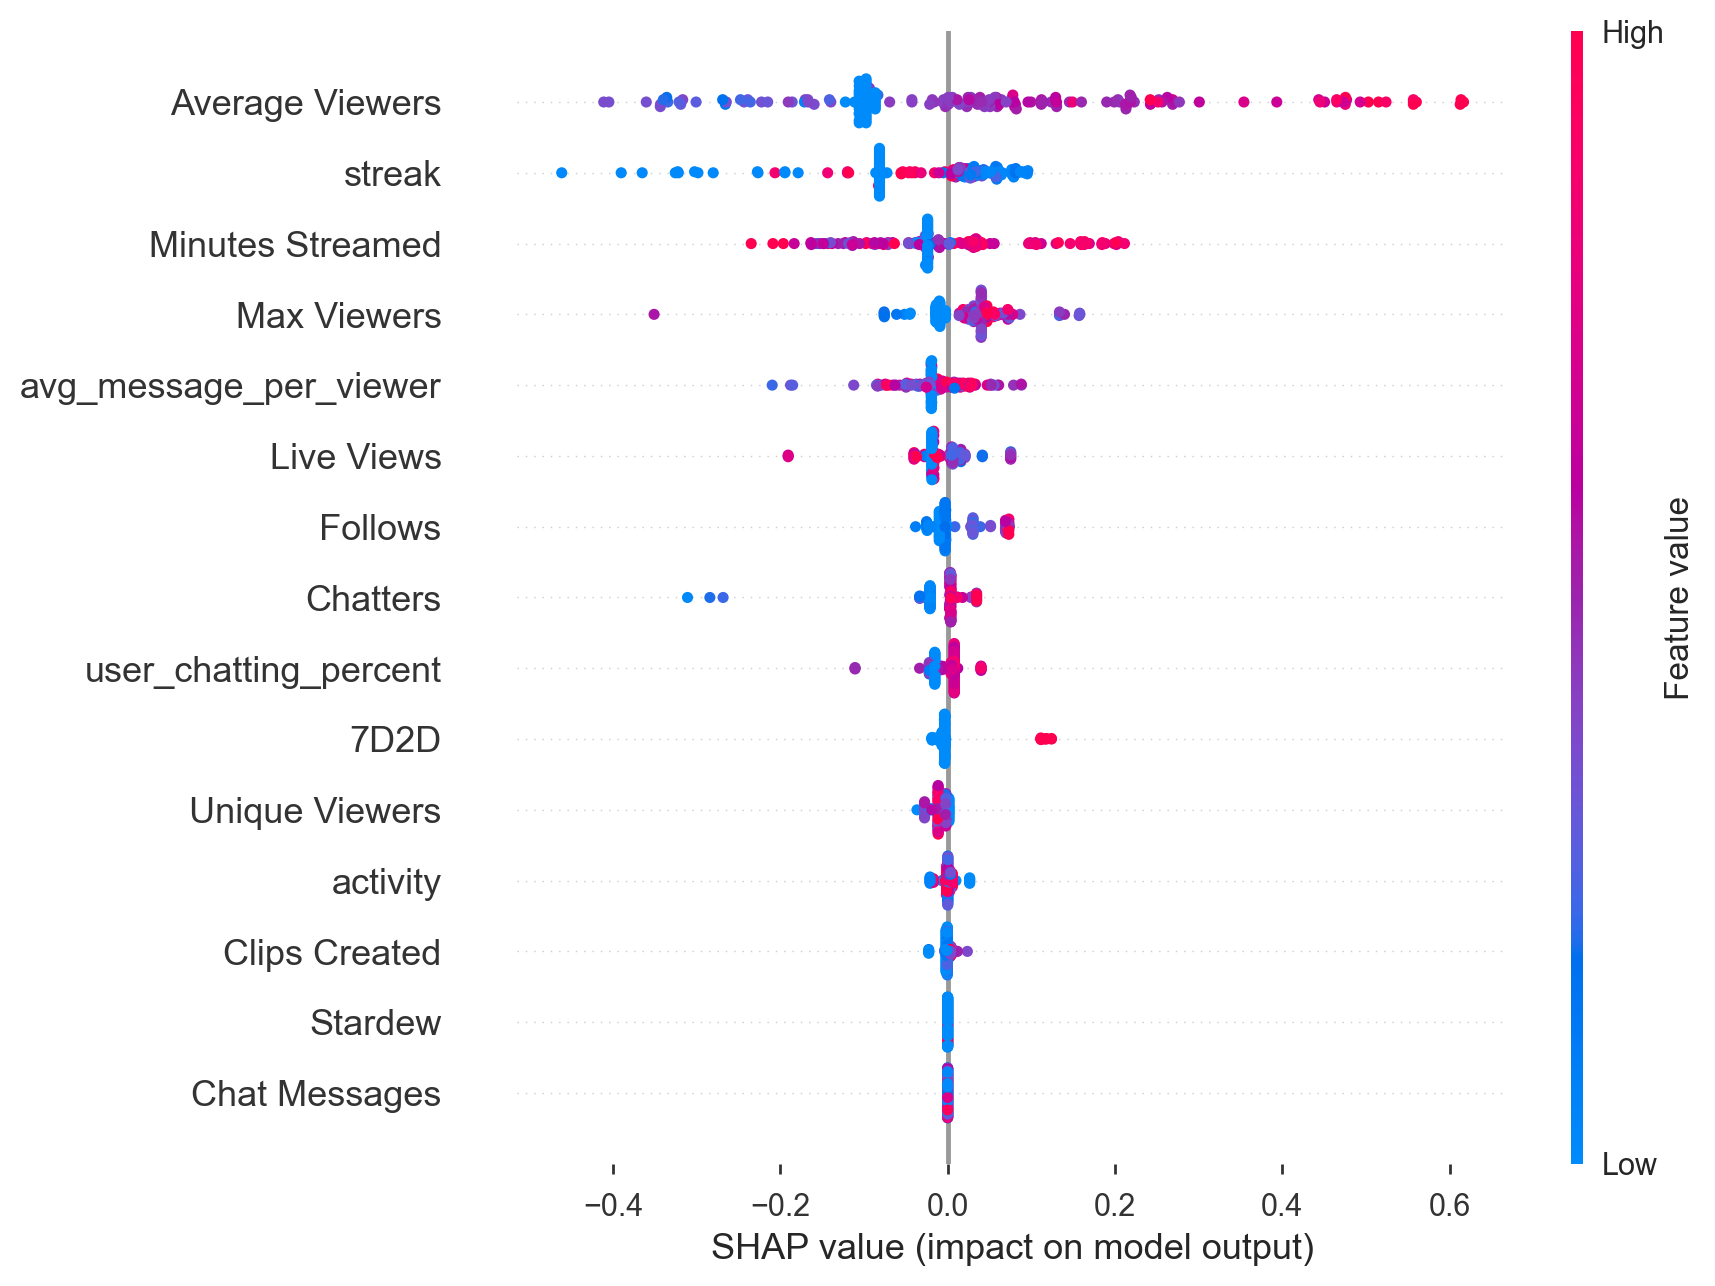

In [111]:
shap.summary_plot(shap_values02[0], X_val)

## Table of Scores for Models


In [112]:
# Validation For Both, Test from Classification Metrics table

model_results_df = pd.DataFrame({"Machine Learning Model": ["Ridge Regression", "Decision Tree Classifier"],
                                    "Baseline Metric": ["MAE: 24.54", "Acc: 0.336"],
                                 "Validation Result": ["MAE: 20.395","Acc: 0.543"],
                                "Test Result": ["-", "Acc: 0.504"]})
model_results_df


Machine Learning Model Baseline Metric Validation Result Test Result
0          Ridge Regression      MAE: 24.54       MAE: 20.395           -
1  Decision Tree Classifier      Acc: 0.336        Acc: 0.543  Acc: 0.504

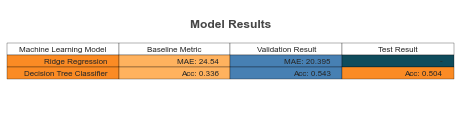

In [266]:
fig, axs = plt.subplots(figsize=(8,2))


lightbl_color = "#4780b3"
lighto_color = "#ffb25e"
middle_color = "#fb8b24"
worse_color= "#0f4c5c"
dnd_color ="#8C031C"


fig.patch.set_visible(False)
axs.axis("tight")
axs.axis("off")

colors = [[middle_color,lighto_color,lightbl_color, worse_color],
          [middle_color, lighto_color, lightbl_color, middle_color]]

table2 = axs.table(cellText=model_results_df.values,
          colLabels=model_results_df.columns,
          cellColours=colors,
          loc = "center")
table2.set_fontsize(60)

table.scale(2,4)

# set title
plt.title('Model Results', fontsize=12,
          fontweight= "bold",
          color= "#454545",
          y=.75)






plt.savefig('model_results_table.png',  dpi=300, bbox_inches="tight")


plt.show()